# Denna notebook är för modelleringen

## Inledning

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [12]:
X = mnist['data']
y = mnist['target'].astype(np.uint8)

print(X.shape)
print(y.shape)
print(X.dtype)

X = X.astype('float32')
y = y.astype('float32')

print(X.dtype)

(70000, 784)
(70000,)
int64
float32


In [13]:
# Delar upp datan i train, val och test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

## EDA

Sanna värdet för bilden 0


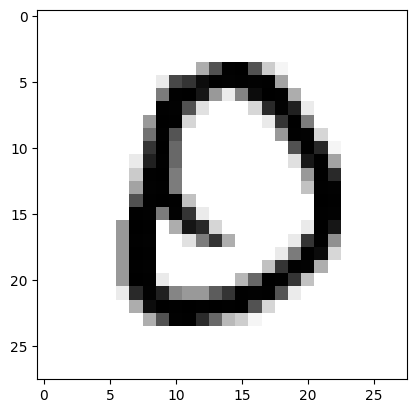

In [14]:
some_digit = X_train[5]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print('Sanna värdet för bilden', y_train[5])

Kontrollerar hur balansen ser ut mellan sifforna. Ifall någon har många färre eller fler än de andra.

Jag ser att 1:orna har 400-500st mer än snittet och 5.or har ca 400 färre. 

In [18]:
pd.Series(y_train).value_counts().sort_index()

0    4136
1    4676
2    4235
3    4292
4    4146
5    3758
6    4101
7    4363
8    4107
9    4186
Name: count, dtype: int64

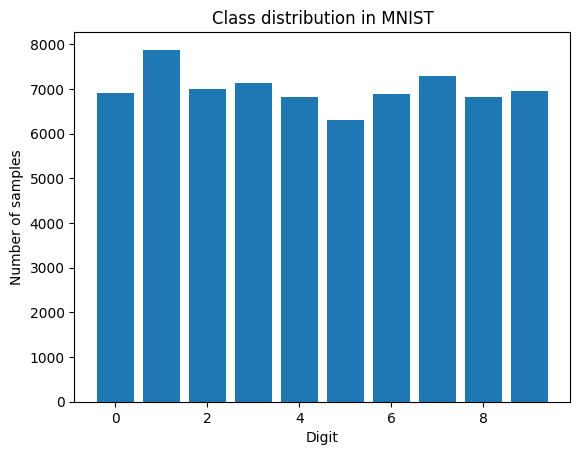

In [20]:
classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)
plt.xlabel("Digit")
plt.ylabel("Number of samples")
plt.title("Class distribution in MNIST")
plt.show()

Nu ska jag kolla på hur variansen inom de olika sifforna ser ut för att veta vad jag har att arbeta med. 

In [ ]:
#En funktion som jag fått hjälp att göra (av ChatGPT eftersom jag inte hade koll på EDA för bild-data) för att enklare kolla alla siffor
def show_examples(X, y, digit, n=16, image_shape=(28, 28)):
    idx = np.where(y == digit)[0][:n]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))

    for ax, i in zip(axes.ravel(), idx):
        img = X[i].reshape(image_shape) if X[i].ndim == 1 else X[i]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.suptitle(f"Examples of digit {digit}")
    plt.tight_layout()
    plt.show()

### Visuell check av variansen inom klasserna

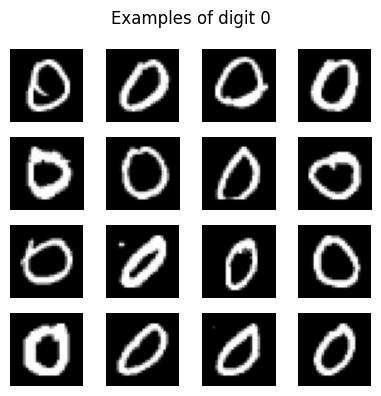

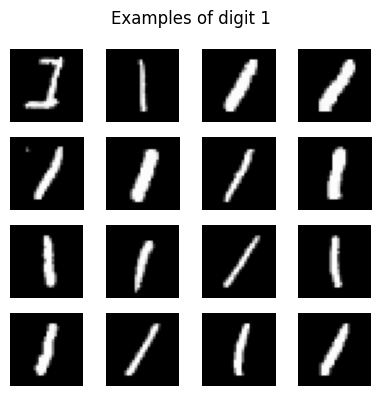

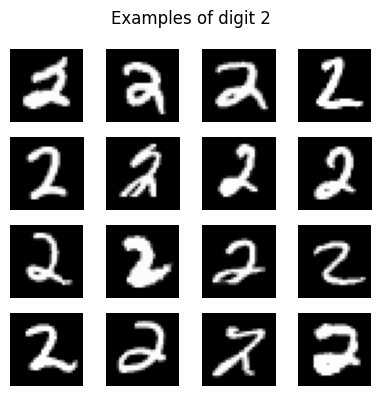

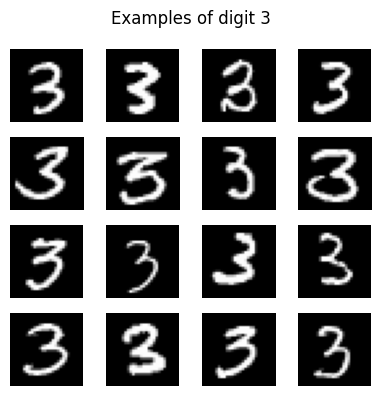

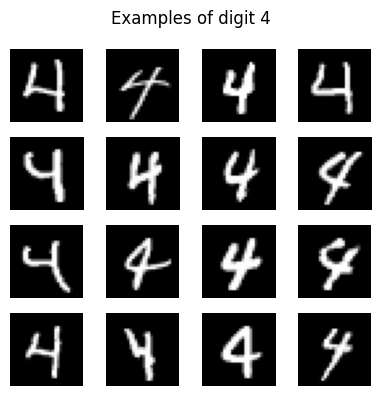

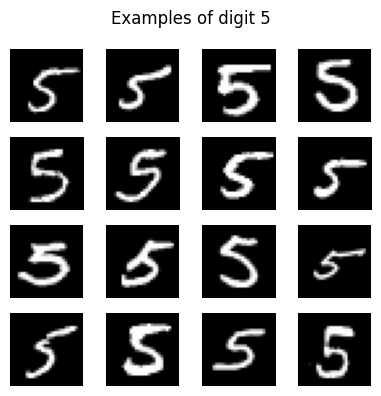

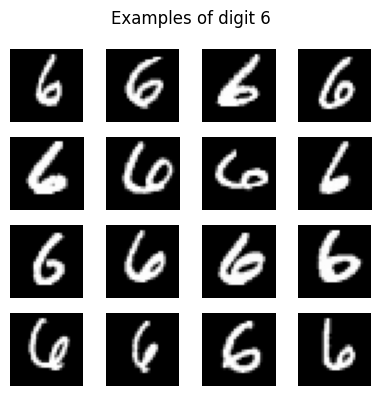

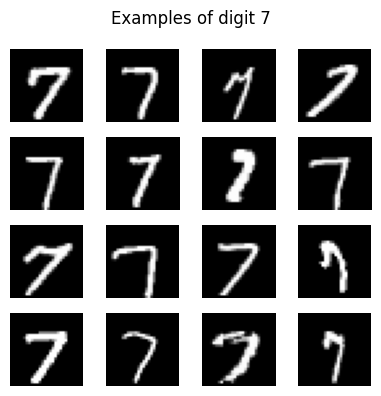

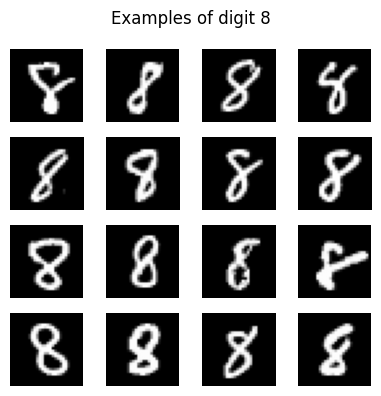

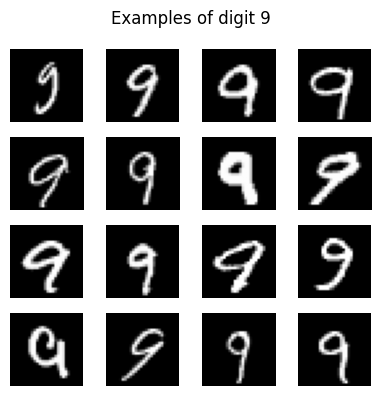

In [27]:
show_examples(X_train, y_train, digit=0)
show_examples(X_train, y_train, digit=1)
show_examples(X_train, y_train, digit=2)
show_examples(X_train, y_train, digit=3)
show_examples(X_train, y_train, digit=4)
show_examples(X_train, y_train, digit=5)
show_examples(X_train, y_train, digit=6)
show_examples(X_train, y_train, digit=7)
show_examples(X_train, y_train, digit=8)
show_examples(X_train, y_train, digit=9)


## Modellering

Börjar med att importera det jag behöver för mina modellering

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA

Gör ett mindre subset som jag kommer att använda för att ta fram hyperparametrana för att det ska gå snabbare och eftersom detta datasetet är så pass homogent så ska det gå bra att skala upp utan att hyperparametrarna blir dåliga. 

Jag gör två subset ett på 15k som jag anväder för de grova hyperparameterkollen och jämförelsen med de olika modellerna och ett sett på 35k för fin justeringen på den modellen jag använder. 

In [36]:
# Subset med 10k och 32k rader: 
X_32k, X_10k, y_32k, y_10k = train_test_split(X_train, y_train, test_size=10000, stratify=y_train, random_state=42)


In [49]:
# modellerna jag kommer börja testa
logref_clf = LogisticRegression(max_iter=1000)
et_clf = ExtraTreesClassifier(n_jobs=1) #Sätter n_jobs till 1 eftersom GridSearchCV kommer ha -1 och detta motverkar nestlad parallellism vilket då blir långsammare
svc_clf = LinearSVC()
kNN_clf = KNeighborsClassifier()

# Lista med modeller, används i träningsloopen
models = [logref_clf, et_clf, svc_clf]

# Vilka hyperparametrar för ExtraTree som ska testas i RandomizedSearchCV
et_param_dist = {
    "n_estimators": randint(200, 650),
    "max_depth": [10, 20, 30],
    "min_samples_leaf": randint(1, 6),
    "min_samples_split": randint(2, 21),
    "max_features": ["sqrt", 0.5],
    "min_impurity_decrease": uniform(0.0, 1e-4)
}

svc_param_dist = {
    "classifier__C": [0.01, 0.1, 1, 10]
}

kNN_param_dist = {
    "classifier__n_neighbors": [5, 8, 15],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean']
}

kNN_pca_param_dist = {
    "pca__n_components": [0.90, 0.95, 0.99, 50, 80, 120],
    "classifier__n_neighbors": [5, 8, 15],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean']
}

svc_pca_param_dist = {
    "pca__n_components": [0.90, 0.95, 0.99, 50, 80, 120],
    "classifier__C": [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# För att spara resultaten från träningsloopen
best_models = {}
best_scores = {}
best_params = {}
val_scores = {}

Jag gjorde först kontrollen av modellerna med en for loop med if-else logik vilket fungerade bra när jag bara hade tre modeller som jag ville testa. Men jag är nyfiken så nu är jag uppe i 4 modeller (två av dom jag började med) och hade velat testa med och utan PCA också. Och när det växte så kände jag att det blev för svårt att hålla koll på att allt blev med parametrar och väldigt oövergripligt. Så min if-else fungerar inte längre pga överskådligheten (den fungerar ju att köra). 

Så min lösning på detta är att göra en lista med alla experiment jag vill genomföra, skapaa en funktion som jag kan använda för att träna med de transformationer de behöver och prediktera mina modeller och sprara resutlatet i mina dictonarys. 

Denna funktion använder jag sen ska använda i for-loopen istället.

In [50]:
experiment = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_dist': None,
        'n_iter': None
    },
    {
        'name': 'ExtraTreesClassifier',
        'estimator': et_clf,
        'param_dist': et_param_dist,
        'n_iter': 50
    },
    {
        'name': 'LinearSVC_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', svc_clf)
        ]),
        'param_dist': svc_param_dist,
        'n_iter': 10
    },
    {
        'name': 'KNeighborsClassifier_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', kNN_clf)
        ]),
        'param_dist': kNN_param_dist,
        'n_iter': 30
    },
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_dist': kNN_pca_param_dist,
        'n_iter': 30
    },
    {
        'name': 'LinearSVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_dist': svc_pca_param_dist,
        'n_iter': 10
    }
]

In [51]:
def fit_and_eval(exp, X_fit, y_fit, X_val, y_val, cv, n_jobs=12, random_state=42, verbose=1):
    # tar ut variablerna från min expriment dict.
    name = exp['name']
    estimator = exp['estimator']
    param_dist = exp['param_dist']
    n_iter = exp['n_iter']

    if param_dist is None:
        estimator.fit(X_fit, y_fit)
        y_pred = estimator.predict(X_val)
        val_score = accuracy_score(y_val, y_pred)

        return {
            "name": name,
            "best_estimator": estimator,
            "best_params": None,
            "best_cv_score": None,
            "val_score": val_score
        }
    
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        refit=True
    )

    search.fit(X_fit, y_fit)
    y_pred = search.predict(X_val)
    val_score = accuracy_score(y_val, y_pred)

    return {
        "name": name,
        "best_estimator": search.best_estimator_,
        "best_params": search.best_params_,
        "best_cv_score": search.best_score_,
        "val_score": val_score
    }

For-loopen:

In [52]:
for exp in experiment:
    result = fit_and_eval(
        exp,
        X_fit=X_10k,
        y_fit=y_10k,
        X_val=X_val,
        y_val=y_val,
        cv=cv,
        n_jobs=12,
        random_state=42,
        verbose=2
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]

    print(f"'\n'----- {name} -----") #adderade lite utsmyckning då det var svårt att se var den ena modellen började och den andra slutade
    print('val_accuracy:', val_scores[name])
    if best_scores[name] is not None:
        print('best_cv_score:', best_scores[name])
        print('best_params:', best_params[name])


'
'----- LogisticRegression_scaled -----
val_accuracy: 0.8807142857142857
Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
for model in models:
    if isinstance(model, ExtraTreesClassifier):
        #Variabel för namnet för att underlätta inläggningen i de olika dict. best_
        model_name = 'ExtraTreesClassifier'

        grid_model = RandomizedSearchCV(
            estimator=et_clf,
            param_distributions=et_param_dist,
            n_iter=50,           
            cv=cv,
            scoring="accuracy",
            n_jobs=12,              
            random_state=42,
            verbose=3
            )
        
        grid_model.fit(X_15k, y_15k)
        y_pred = grid_model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = grid_model.best_estimator_
        best_scores[model_name] = grid_model.best_score_
        best_params[model_name] = grid_model.best_params_

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))
        print(model_name, '\t', grid_model.best_params_)
        print(model_name, '\t', grid_model.best_score_)
        
    elif isinstance(model, LinearSVC):
        model_name = 'LinearSVC'

        model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        #använder GridSearchCV här då det är så få hyperparametrar att testa
        grid_model = GridSearchCV(
            estimator=model,
            param_grid=svc_param_dict,         
            cv=cv,
            scoring="accuracy",
            n_jobs=12,              
            random_state=42,
            verbose=3
            )
        
        grid_model.fit(X_15k, y_15k)
        y_pred = grid_model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = grid_model.best_estimator_
        best_scores[model_name] = grid_model.best_score_
        best_params[model_name] = grid_model.best_params_

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))
        print(model_name, '\t', grid_model.best_params_)
        print(model_name, '\t', grid_model.best_score_)

    elif isinstance(model, KNeighborsClassifier):
        model_name = 'KNeighborsClassifier'

        model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', model)
        ])

        grid_model = RandomizedSearchCV(
            estimator=model,
            param_distributions=kNN_param_dict,
            n_iter=30,           
            cv=cv,
            scoring="accuracy",
            n_jobs=12,              
            random_state=42,
            verbose=3
            )
        
        grid_model.fit(X_15k, y_15k)
        y_pred = grid_model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = grid_model.best_estimator_
        best_scores[model_name] = grid_model.best_score_
        best_params[model_name] = grid_model.best_params_

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))
        print(model_name, '\t', grid_model.best_params_)
        print(model_name, '\t', grid_model.best_score_)

    else:
        model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        #Variabel för namnet för att underlätta inläggningen i de olika dict. best_
        model_name = 'LogisticRegression'

        model.fit(X_15k, y_15k) #Använder subsetet här med inte för att det behöver gå snabbare utan för att det ska vara jämförbart med resten
        y_pred = model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = model
        best_scores[model_name] = accuracy_score(y_val, y_pred)
        best_params[model_name] = None

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))


LogisticRegression 	 0.8842142857142857
Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# modellerna jag kommer börja testa
logref_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_jobs=1) #Sätter n_jobs till 1 eftersom GridSearchCV kommer ha -1 och detta motverkar nestlad parallellism vilket då blir långsammare
et_clf = ExtraTreesClassifier(n_jobs=1)

# Lista med modeller, används i träningsloopen
models = [logref_clf, rf_clf, et_clf]

# Vilka hyperparametrar för RandomForest som ska testas i GridSearhCV
rf_param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [None],
    "min_samples_leaf": [1, 2],
    "min_samples_split": [2, 10],
    "max_features": ["sqrt", 0.3]
}

# Vilka hyperparametrar för ExtraTree som ska testas i GridSearhCV
et_param_grid = {
    "n_estimators": [125, 250, 500],
    "max_depth": [None, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", 0.3, 0.5]
}

# Vilka parametrar jag vill ha för cv i GridSearchCV
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# För att spara resultaten från träningsloopen
best_models = {}
best_scores = {}
best_params = {}

In [47]:
for model in models:
    #RandomForest
    if isinstance(model, RandomForestClassifier):
        #Variabel för namnet för att underlätta inläggningen i de olika dict. best_
        model_name = 'RandomForestClassifier'

        grid_model = GridSearchCV(
            estimator=rf_clf,
            param_grid=rf_param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_model.fit(X_train, y_train)
        y_pred = grid_model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = grid_model.best_estimator_
        best_scores[model_name] = grid_model.best_score_
        best_params[model_name] = grid_model.best_params_

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))
        print(model_name, '\t', grid_model.best_params_)
        print(model_name, '\t', grid_model.best_score_)
        
    elif isinstance(model, ExtraTreesClassifier):

        #Variabel för namnet för att underlätta inläggningen i de olika dict. best_
        model_name = 'ExtraTreesClassifier'

        grid_model = GridSearchCV(
            estimator=et_clf,
            param_grid=et_param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_model.fit(X_train, y_train)
        y_pred = grid_model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = grid_model.best_estimator_
        best_scores[model_name] = grid_model.best_score_
        best_params[model_name] = grid_model.best_params_

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))
        print(model_name, '\t', grid_model.best_params_)
        print(model_name, '\t', grid_model.best_score_)

    else:
        model = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        #Variabel för namnet för att underlätta inläggningen i de olika dict. best_
        model_name = 'LogisticRegression'

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # sparar datan från iterationen i dict. best_
        best_models[model_name] = model
        best_scores[model_name] = accuracy_score(y_val, y_pred)
        best_params[model_name] = None

        # Printa resultatet
        print(model_name, '\t', accuracy_score(y_val, y_pred))


LogisticRegression 	 0.9101428571428571


: 

Går vidare

In [ ]:
rf_model = best_models['RandomForestClassification']